# Fraud Detection using LightGBM and SMOTE

### Introduction
We use the dataset of [ULB Creditcard Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) to train our frauld detection model. In this notebook, we preprocess the dataset and generate features, which refers to some execellent work listed as below:

* **Fraud detection handbook**: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html
* **AWS creditcard fraud detector**: https://github.com/awslabs/fraud-detection-using-machine-learning/blob/master/source/notebooks/sagemaker_fraud_detection.ipynb
* **Creditcard fraud detection predictive models**: https://www.kaggle.com/code/gpreda/credit-card-fraud-detection-predictive-models

In [1]:
import pyspark
import yaml
import argparse
import onnxmltools
import subprocess
import lightgbm as lgb
import numpy as np
import pandas as pd
import warnings

from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
def init_spark():
    spark = pyspark.sql.SparkSession.builder\
            .appName("Fraud Detection-LightGBM") \
            .config("spark.executor.memory","8G") \
            .config("spark.executor.instances","4") \
            .config("spark.executor.cores", "4") \
            .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
            .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
            .getOrCreate()
    sc = spark.sparkContext
    print(sc.version)
    print(sc.applicationId)
    print(sc.uiWebUrl)
    return spark

def load_config(path):
    params = dict()
    with open(path, 'r') as stream:
        params = yaml.load(stream, Loader=yaml.FullLoader)
    return params

def read_dataset(spark, data_path):
    dataset = spark.read.format("csv")\
      .option("header",  True)\
      .option("inferSchema",  True)\
      .load(data_path)  
    return dataset

def get_vectorassembler(dataset, features='features', label='label'):
    featurizer = VectorAssembler(
        inputCols = feature_cols,
        outputCol = 'features',
        handleInvalid = 'skip'
    )
    dataset = featurizer.transform(dataset)[label, features]
    return dataset

In [3]:
!aws s3 ls s3://dmetasoul-bucket/demo/risk/ulb/

2022-07-20 06:08:16          0 
2022-07-20 06:08:35  150828752 creditcard.csv
2022-07-21 07:45:38    9368900 creditcard_test.csv
2022-07-21 07:45:35   84318327 creditcard_train.csv
2022-07-21 07:45:40   92424439 creditcard_train_smote.csv


In [4]:
spark = init_spark()

https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1
Ivy Default Cache set to: /home/spark/.ivy2/cache
The jars for the packages stored in: /home/spark/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b23dac9a-59c1-42ff-bd01-34072dd718ba;1.0
	confs: [default]


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.microsoft.azure#synapseml_2.12;0.9.4 in repo-1
	found com.microsoft.azure#synapseml-core_2.12;0.9.4 in repo-1
	found org.scalactic#scalactic_2.12;3.0.5 in central
	found org.scala-lang#scala-reflect;2.12.4 in central
	found io.spray#spray-json_2.12;1.3.2 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents#httpclient;4.5.6 in central
	found org.apache.httpcomponents#httpcore;4.4.10 in central
	found commons-logging#commons-logging;1.2 in central
	found commons-codec#commons-codec;1.10 in central
	found org.apache.httpcomponents#httpmime;4.5.6 in central
	found com.linkedin.isolation-forest#isolation-forest_3.0.0_2.12;1.0.1 in central
	found com.chuusai#shapeless_2.12;2.3.2 in central
	found org.typelevel#macro-compat_2.12;1.1.1 in central
	found org.apache.spark#spark-avro_2.12;3.0.0 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.testng#testng;6.8.8 in central
	found org.beanshell#bsh;2.0b4 in central
	found com.b

3.1.2
spark-application-1658401872888
http://10.0.50.41:4040


### Train detection model using LightGBM

In [5]:
fg_train_dataset = read_dataset(spark, 's3://dmetasoul-bucket/demo/risk/ulb/creditcard_train.csv')
fg_test_dataset = read_dataset(spark, 's3://dmetasoul-bucket/demo/risk/ulb/creditcard_test.csv')

In [6]:
fg_train_dataset.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

The dataset contains only numerical features, because the original features have been transformed using PCA. As a result, the dataset contains 28 PCA components, V1-V28, and two features that haven't been transformed, `Amount` and `Time`. Amount refers to the transaction amount, and Time is the seconds elapsed between any transaction in the data and the first transaction.Moreover, The `Class` column corresponds to whether or not a transaction is fraudulent. 


> https://github.com/awslabs/fraud-detection-using-machine-learning

In [7]:
fg_train_dataset.groupby('Class').count().toPandas()

,Class,count
0,0.0,255880
1,1.0,446


In [8]:
fg_test_dataset.groupby('Class').count().toPandas()

,Class,count
0,0.0,28435
1,1.0,46


In [9]:
feature_cols = fg_train_dataset.columns[:-1]
feature_cols

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [10]:
label_col = fg_train_dataset.columns[-1]
label_col

'Class'

In [11]:
train_data = get_vectorassembler(fg_train_dataset, label=label_col, features='features')
test_data = get_vectorassembler(fg_test_dataset, label=label_col, features='features')

In [12]:
train_data.limit(10).toPandas()

22/07/21 11:11:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,Class,features
0,0.0,"[28515.0, 1.2266432, 0.10198813, -0.08707244, ..."
1,0.0,"[83125.0, 1.1248479, 0.12560174, 0.2499616, 0...."
2,0.0,"[75537.0, -0.30790162, 1.0037148, 1.4042773, 0..."
3,0.0,"[156358.0, 2.1749187, -1.5354409, -0.72642803,..."
4,0.0,"[162523.0, -2.221556, 1.2619867, 2.0476425, 4...."
5,0.0,"[113992.0, -0.33519775, 0.8713775, 0.6327032, ..."
6,0.0,"[18653.0, -1.3059778, 1.7721184, 0.7417298, 0...."
7,0.0,"[133445.0, -0.30335563, 1.1449964, -0.84363854..."
8,0.0,"[87252.0, -0.46592036, 0.6283648, 1.4495686, 4..."
9,0.0,"[40607.0, 0.2710954, -2.7204888, 0.42742714, -..."


We split train dataset for model training and validation

In [13]:
train, valid = train_data.randomSplit([0.90, 0.10], seed=2022)

In [14]:
train.count()

230649

In [15]:
valid.count()

25677

### Train model
Here we are using `isUnbalance=True`, please refer to [LightGBM docs](https://mmlspark.blob.core.windows.net/docs/0.18.1/pyspark/mmlspark.lightgbm.html) for the description of this parameter.

In [16]:
model_params =  {
    'boostingType':'gbdt',
    'objective':'binary',
    'metric':'auc',
    'numLeaves': 7,
    'maxDepth': 4,
    'minDataInLeaf': 100,
    'maxBin': 100,
    'minGainToSplit': 0.0,
    'featureFraction': 0.7,
    'baggingFraction': 0.9,
    'baggingFreq': 1,
    'learningRate': 0.01,
    'numIterations': 300,
    'earlyStoppingRound': 100,
    'verbosity':1,
    'numThreads':16,
}

def train_lightgbm(train_dataset, feature_col, label_col, model_params):
    from synapse.ml.lightgbm import LightGBMClassifier
    model = LightGBMClassifier(isProvideTrainingMetric=True, featuresCol=feature_col, labelCol=label_col, isUnbalance=True, **model_params)
    model = model.fit(train_dataset)
    return model

def evaluate(predictions, label_col, metricName="areaUnderROC"):
    evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName="areaUnderROC")
    return evaluator.evaluate(predictions)

model = train_lightgbm(train, 'features', 'Class', model_params)

In [17]:
print("train dataset prediciton:")
predictions = model.transform(train)
print("train dataset auc:", evaluate(predictions, label_col))

train dataset prediciton:


train dataset auc: 0.9985029478114258


In [18]:
print("validation dataset prediciton:")
predictions = model.transform(valid)
print("validation dataset auc:", evaluate(predictions, label_col))

validation dataset prediciton:


validation dataset auc: 0.9968178093417098


In [19]:
importance_df = (
    pd.DataFrame({
        'feature_name': feature_cols,
        'importance_gain': model.getFeatureImportances('gain'),
        'importance_split': model.getFeatureImportances('split'),
    })
    .sort_values('importance_gain', ascending=False)
    .reset_index(drop=True)
)
print(importance_df)

   feature_name  importance_gain  importance_split
0           V14     4.630515e+07             148.0
1            V4     5.301995e+06             165.0
2           V12     2.721155e+06             102.0
3        Amount     8.172066e+05              48.0
4           V10     5.766082e+05             155.0
5           V20     4.225038e+05              39.0
6            V8     3.625148e+05              89.0
7           V19     3.486154e+05              76.0
8           V26     2.968970e+05              78.0
9            V7     2.945563e+05              85.0
10          V11     2.551122e+05              79.0
11           V3     2.386089e+05              88.0
12          V13     2.174639e+05              26.0
13          V17     1.933528e+05              45.0
14          V18     1.640645e+05              39.0
15         Time     1.358549e+05              65.0
16           V5     1.241138e+05              72.0
17          V16     1.194525e+05              49.0
18          V28     1.183668e+0

In [20]:
model = train_lightgbm(train_data, 'features', 'Class', model_params)

In [21]:
print("test dataset prediciton:")
predictions = model.transform(test_data)
print("test dataset auc:", evaluate(predictions, label_col))

test dataset prediciton:


test dataset auc: 0.9738350624230709


In [22]:
predictionAndLabels = predictions.select('prediction', F.col(label_col).cast(DoubleType()))\
                                 .withColumnRenamed(label_col, 'label')
metrics = MulticlassMetrics(predictionAndLabels.rdd)

<AxesSubplot:>

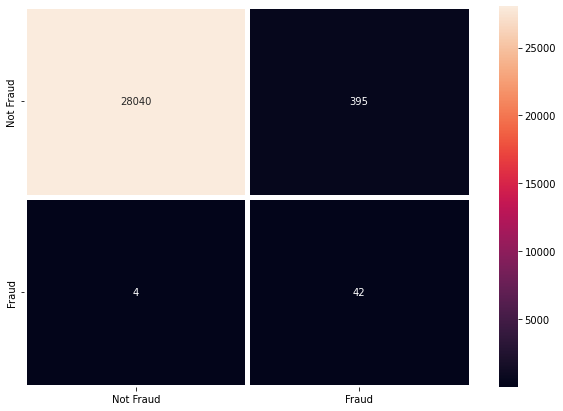

In [23]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(metrics.confusionMatrix().toArray(), 
           xticklabels=['Not Fraud', 'Fraud'],
           yticklabels=['Not Fraud', 'Fraud'],
           linewidths=5, fmt='g', annot=True)

### SMOTE
Now we have a baseline model using LightGBM. Let us will verify the over sampling tricks on traning data that using SMOTE.

In [24]:
fg_train_smote_dataset = read_dataset(spark, 's3://dmetasoul-bucket/demo/risk/ulb/creditcard_train_smote.csv')
train_smote_data = get_vectorassembler(fg_train_smote_dataset, label=label_col, features='features')
train_smote_data.groupby('Class').count().toPandas()

,Class,count
0,0.0,255880
1,1.0,25588


In [25]:
model = train_lightgbm(train_smote_data, 'features', 'Class', model_params)

In [26]:
print("test dataset prediciton:")
predictions = model.transform(test_data)
print("test dataset auc:", evaluate(predictions, label_col))

test dataset prediciton:


test dataset auc: 0.9664341251213686


In [27]:
predictionAndLabels = predictions.select('prediction', F.col(label_col).cast(DoubleType()))\
                                 .withColumnRenamed(label_col, 'label')
metrics = MulticlassMetrics(predictionAndLabels.rdd)

<AxesSubplot:>

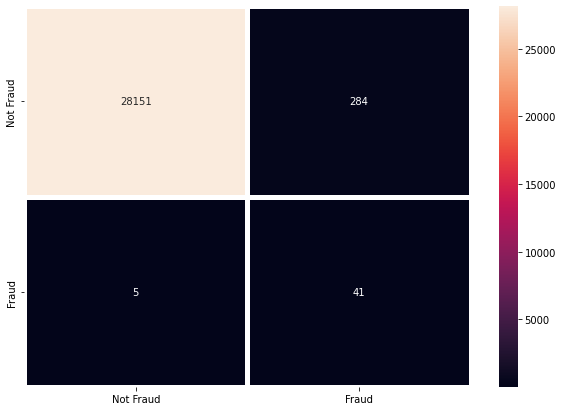

In [28]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(metrics.confusionMatrix().toArray(), 
           xticklabels=['Not Fraud', 'Fraud'],
           yticklabels=['Not Fraud', 'Fraud'],
           linewidths=5, fmt='g', annot=True)

In [29]:
spark.stop()

22/07/21 11:12:10 WARN ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed (this is expected if the application is shutting down.)
